# Variational inference with the mean field approximation
## Application to the Gaussian model with latent mean and precision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from scipy.special import gamma as gamma_function 
from scipy.stats import norm
from scipy.stats import gamma

In [2]:
def plot_normal_gamma(mean_norm, precision_norm, shape_gamma, rate_gamma, N=100, ax=None):
    
    std_norm = np.sqrt(1/precision_norm)
    mean_gamma = shape_gamma/rate_gamma
    std_gamma = np.sqrt(shape_gamma/rate_gamma**2)
    
    mus = np.linspace(mean_norm-3*std_norm, mean_norm+3*std_norm, N)
    
    taus = np.linspace(0.001, mean_gamma + 3*std_gamma, N)
    
    M, T = np.meshgrid(mus, taus, indexing="ij")
    pdf = np.zeros_like(M)

    for i in range(pdf.shape[0]):
        for j in range(pdf.shape[1]):
            pdf[i,j] = (norm.pdf(mus[i], mean_norm, std_norm) * 
                                gamma.pdf(taus[j], a=shape_gamma, loc=0, scale=1/rate_gamma))

    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.subplot(111)
        
    step = np.mean(pdf)
    levels = np.arange(0.0, np.amax(pdf), step) + step    
    
    ax.contour(M, T, pdf, levels, cmap=cm.Blues, alpha=1)
    ax.set_xlabel(r'$\mu$', fontsize=15)
    ax.set_ylabel(r'$\tau$', fontsize=15)
    ax.set_title('Normal x Gamma pdf', fontsize=15)
    
    return ax
        
def plot_normal(mean, precision, N=100, ax=None):
    
    std = np.sqrt(1/precision)

    mus = np.linspace(mean - 3*std, mean + 3*std, N)

    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    ax.plot(mus, norm.pdf(mus, mean, std))
    ax.set_xlabel(r'$\mu$', fontsize=15)
    ax.set_title('Gaussian pdf', fontsize=15)
    
    return ax

def plot_gamma(shape, rate, N=100, ax=None):
    
    mean = shape/rate
    std = np.sqrt(shape/rate**2)
    
    taus = np.linspace(0.001, mean + 3*std, N)

    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    ax.plot(taus, gamma.pdf(taus, a=shape, loc=0, scale=1/rate))
    ax.set_xlabel(r'$\tau$', fontsize=15)
    ax.set_title('Gamma pdf', fontsize=15)
    
    return ax

## Priors

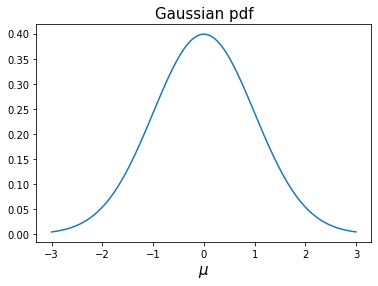

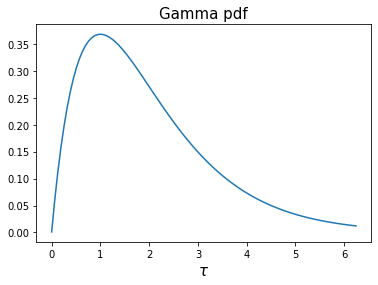

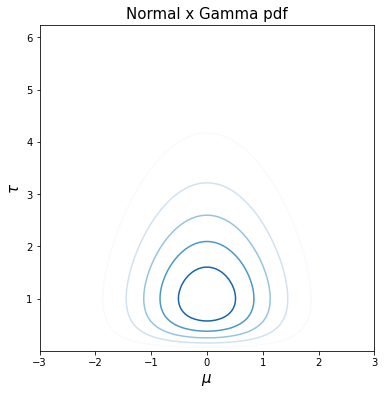

In [3]:
# Prior for the mean

mu_0 = 0
lambda_0 = 1

plot_normal(mu_0, lambda_0)

# Prior for the precision

a_0 = 2
b_0 = 1

plot_gamma(a_0, b_0)

# 2D plot of the joint pdf

plot_normal_gamma(mean_norm=mu_0, precision_norm=lambda_0, 
                  shape_gamma=a_0, rate_gamma=b_0, N=100)

## Data generation

mu = -1.0000 - tau = 3.0000


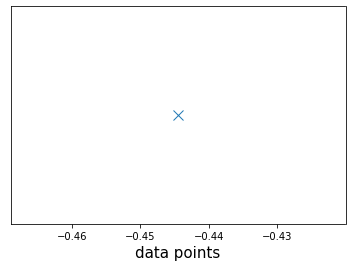

In [4]:
# mu_true = mu_0 + np.sqrt(1/lambda_0) * np.random.randn()
# tau_true = np.random.gamma(shape=a_0, scale=b_0)

mu_true = -1
tau_true = 3

N = 1

x = mu_true + np.sqrt(1/tau_true) * np.random.randn(N,1)

x_bar = np.mean(x)
plt.plot(x,np.ones_like(x), 'x', markersize=10)
plt.yticks([])
plt.xlabel('data points', fontsize=15)

print('mu = %.4f - tau = %.4f' % (mu_true, tau_true))

## True posterior

We first compute $p(\tau | \mathbf{x})$.

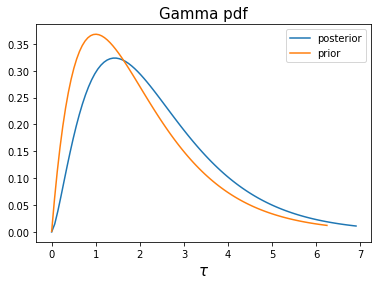

In [5]:
alpha = a_0 + N/2

beta = ( b_0 + 
         0.5*np.sum((x - x_bar)**2) + 
         0.5*lambda_0*N/(lambda_0 + N)*(x_bar - mu_0)**2 )

plt.figure()
ax = plt.subplot(111)
plot_gamma(alpha, beta, ax=ax)
plot_gamma(a_0, b_0, ax=ax)
plt.legend(['posterior', 'prior'])

In [6]:
prior_mean_tau = a_0/b_0
prior_std_tau = np.sqrt(a_0/b_0**2)

post_mean_tau = alpha/beta
post_std_tau = np.sqrt(alpha/beta**2)

print('prior mean: %.4f, prior std: %.4f' % (prior_mean_tau, prior_std_tau))
print('posterior mean: %.4f, posterior std: %.4f' % (post_mean_tau, post_std_tau))

prior mean: 2.0000, prior std: 1.4142
posterior mean: 2.3823, posterior std: 1.5067


Then we need to compute $p(\mu | \mathbf{x}, \tau)$ and finally $p(\mu, \tau | \mathbf{x}) = p(\mu | \mathbf{x}, \tau)p(\tau | \mathbf{x})$.


In [7]:
taus = np.linspace(0.001, post_mean_tau+3*post_std_tau, 100)

approx_mu_star = ( N*post_mean_tau/(N*post_mean_tau + lambda_0*post_mean_tau)*x_bar +
                   lambda_0*post_mean_tau/(N*post_mean_tau + lambda_0*post_mean_tau)*mu_0 )
approx_lambda_star = N*post_mean_tau + lambda_0*post_mean_tau

mus = np.linspace(approx_mu_star - 3*np.sqrt(1/approx_lambda_star), 
                  approx_mu_star + 3*np.sqrt(1/approx_lambda_star), 
                  100)

M, T = np.meshgrid(mus, taus, indexing="ij")
posterior = np.zeros_like(M)

for i in range(posterior.shape[0]):
    for j in range(posterior.shape[1]):
        
        tau = taus[j]
        mu = mus[i]
               
        mu_star = ( N*tau/(N*tau + lambda_0*tau)*x_bar +
                   lambda_0*tau/(N*tau + lambda_0*tau)*mu_0 )
        
        lambda_star = N*tau + lambda_0*tau + 1e-10
        
        posterior[i][j] = ( norm.pdf(mu, mu_star, np.sqrt(1/lambda_star)) * 
                   gamma.pdf(tau, a=alpha, loc=0, scale=1/beta) )

 

Let's plot the resulting posterior.

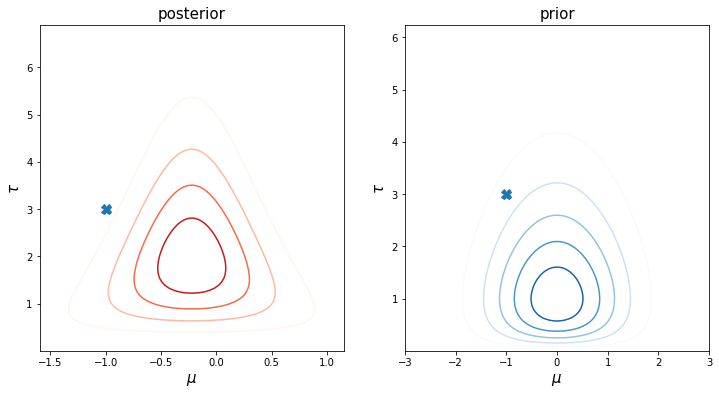

In [8]:
def plot_posterior():

    step = np.mean(posterior)
    levels = np.arange(0.0, np.amax(posterior), step) + step
    
    plt.figure(figsize=(12,6))

    ax = plt.subplot(121)
    ax.contour(M, T, posterior, levels, cmap=cm.Reds, alpha=1)
    ax.set_title('posterior', fontsize=15)
    ax.set_xlabel(r'$\mu$', fontsize=15)
    ax.set_ylabel(r'$\tau$', fontsize=15)
    
    return ax

ax = plot_posterior()
ax.plot(mu_true, tau_true, 'X', markersize=10)

ax = plt.subplot(122)
plot_normal_gamma(mean_norm=mu_0, precision_norm=lambda_0, 
                  shape_gamma=a_0, rate_gamma=b_0, N=100, ax=ax)
ax.set_title('prior', fontsize=15)
ax.plot(mu_true, tau_true, 'X', markersize=10)

Same figure, but we overlay the prior and the posterior.

Text(0.5, 1.0, 'red: posterior, blue: prior')

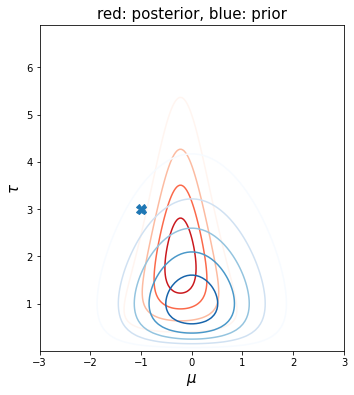

In [9]:
ax = plot_posterior()
plot_normal_gamma(mean_norm=mu_0, precision_norm=lambda_0, 
                  shape_gamma=a_0, rate_gamma=b_0, N=100, ax=ax)
ax.plot(mu_true, tau_true, 'X', markersize=10)
ax.set_title('red: posterior, blue: prior', fontsize=15)

## Mean field approximation

Let's now compute the mean field approximation of the true posterior.

We first initialize the variational parameters.

In [10]:
mu_N = 5
lambda_N = 0.5
a_N = 10
b_N = 5

Let's compare with the true posterior.

Text(0.5, 1.0, 'red: posterior, blue: mean field approx.')

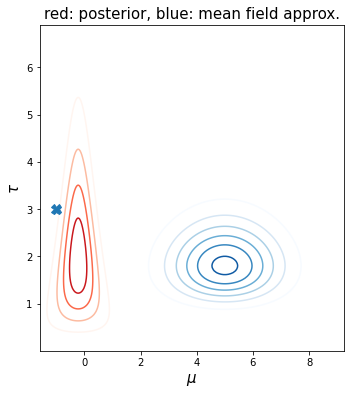

In [11]:
ax = plot_posterior()

plot_normal_gamma(mean_norm=mu_N, precision_norm=lambda_N, 
                  shape_gamma=a_N, rate_gamma=b_N, N=100, ax=ax)

ax.plot(mu_true, tau_true, 'X', markersize=10)

ax.set_title('red: posterior, blue: mean field approx.', fontsize=15)

Update $\mu_N$ and $\lambda_N$, the parameters of $q_\mu(\mu)$, and compare the new variational distribution with the true posterior.

Text(0.5, 1.0, 'red: posterior, blue: mean field approx.')

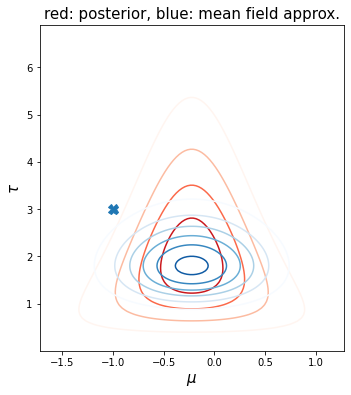

In [12]:
exp_tau = a_N/b_N

mu_N = (lambda_0*mu_0 + N * x_bar)/(lambda_0 + N)
lambda_N = exp_tau*(lambda_0 + N)

ax = plot_posterior()

plot_normal_gamma(mean_norm=mu_N, precision_norm=lambda_N, 
                  shape_gamma=a_N, rate_gamma=b_N, N=100, ax=ax)

ax.plot(mu_true, tau_true, 'X', markersize=10)

ax.set_title('red: posterior, blue: mean field approx.', fontsize=15)

Update $a_N$ and $b_N$, the parameters of $q_\tau(\tau)$, and compare the new variational distribution with the true posterior.

Text(0.5, 1.0, 'red: posterior, blue: mean field approx.')

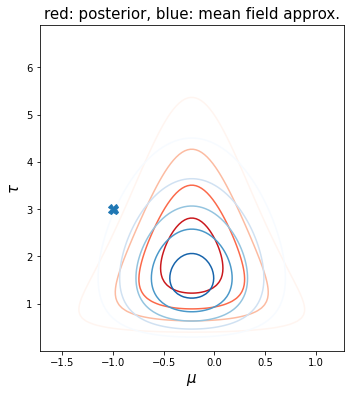

In [13]:
exp_mu = mu_N
exp_mu2 = mu_N**2 + 1/lambda_N

a_N = a_0 +(N+1)/2
b_N = b_0 + 0.5 * (np.sum(x**2)+exp_mu2 * (lambda_0 + N) - 2*exp_mu*(lambda_0*mu_0+N*x_bar)+lambda_0*mu_0**2)


ax = plot_posterior()

plot_normal_gamma(mean_norm=mu_N, precision_norm=lambda_N, 
                  shape_gamma=a_N, rate_gamma=b_N, N=100, ax=ax)

ax.plot(mu_true, tau_true, 'X', markersize=10)

ax.set_title('red: posterior, blue: mean field approx.', fontsize=15)

- With N=1 observation, the modes of both the true posterior and its variational approximation are far from the true values of $\mu$ and $\tau$. Try with N=10, 100, or 1000, what do you observe?

- Compute the ELBO and verify that after each update of the variational parameters, it increases.